In [160]:
from keras import applications
from keras.preprocessing import image
import os
import requests
import io
import tarfile
import skimage
from glob import glob
import matplotlib.pyplot as plt
from skimage import io as imageIO
%matplotlib inline
import random
import shutil #package we will use to move files
from sklearn import linear_model

In [161]:
inception = applications.inception_v3.InceptionV3(include_top=False,
                                                  weights='imagenet',
                                                  input_shape=(250,250,3))

In [162]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw-a.tgz'
base = os.getcwd()
tmp = 'faces' #specify a location to store the images we will work with
loc = os.path.join(base, tmp)
if not os.path.isdir(loc): #make a directory to store the images in
    os.mkdir(loc)
r = requests.get(url)
if r.status_code == 200: #if the GET request is successful
    hold = io.BytesIO(r.content)
    f = tarfile.open(fileobj=hold) #load the tarfile into a tarfile object for extraction
    f.extractall(loc)
    people = os.listdir(os.path.join(loc, 'lfw'))

if people:
    print("We now have {} folders with images of different people's faces".format(len(people)))

We now have 432 folders with images of different people's faces


In [163]:
most = [0, '']
for folder in people:
    path = os.path.join(loc, 'lfw', folder)
    num = len(os.listdir(path))
    if num > most[0]:
        most[0] = num
        most[1] = folder
        
print('{} has the most pictures with {}'.format(most[1], most[0]))

Ariel_Sharon has the most pictures with 77


('The image dimensions are ', (250, 250, 3))


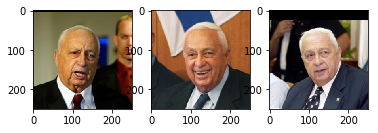

In [164]:
positive_paths = glob(os.path.join(loc, 'lfw',most[1],'*'))
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
example = imageIO.imread(positive_paths[0])
print("The image dimensions are ", example.shape)
ax1.imshow(example)
ax2.imshow(imageIO.imread(positive_paths[1]))
ax3.imshow(imageIO.imread(positive_paths[2]))

In [165]:
image_root = 'target_ariel'
image_root = os.path.join(loc, image_root)
train = os.path.join(image_root, 'train/')
test = os.path.join(image_root, 'test/')
trainpositive = os.path.join(image_root, 'train/positive/')
testpositive = os.path.join(image_root, 'test/positive/')
trainnegative = os.path.join(image_root, 'train/negative/')
testnegative = os.path.join(image_root, 'test/negative/')

if not os.path.isdir(image_root):
    os.mkdir(image_root) #create the new root folder
    
if not os.path.exists(train):
    os.mkdir(train) #folder to hold all of the pictures of Ariel
    os.mkdir(trainpositive) #folder to hold all of the pictures of Ariel
    os.mkdir(trainnegative) #folder to hold pictures of everyone else
   
if not os.path.exists(test):
    os.mkdir(test) #folder to hold all of the pictures of Ariel
    os.mkdir(testpositive) #folder to hold all of the pictures of Ariel
    os.mkdir(testnegative) #folder to hold pictures of everyone else
    
#now loop over all of the images and copy them to the appropriate folder
counter=0
for folder in people:
    counter+=1
    path = os.path.join(loc, 'lfw', folder)
    images = glob(os.path.join(path, '*.jpg'))
    if folder is not most[1]:
        for image2 in images:
            rand=random.random()
            if rand>0.3:
                dest = trainnegative
                shutil.copy2(image2, dest)
            else:
                dest = testnegative
                shutil.copy2(image2, dest)
    else:
        for image2 in images:
            rand=random.random()
            if rand>0.3:
                dest = trainpositive
                shutil.copy2(image2, dest)
            else:
                dest = testpositive
                shutil.copy2(image2, dest)
num_trainpositive = len(os.listdir(trainpositive))
num_testpositive = len(os.listdir(testpositive))
num_trainnegative = len(os.listdir(trainnegative))
num_testnegative = len(os.listdir(testnegative))
#Print out some results to verify that everything worked as expected
print('The number of train positive images is {}'.format(num_trainpositive))
print('The number of test positive images is {}'.format(num_testpositive))
print('The number of train negative images is {}'.format(num_trainnegative))
print('The number of test negative images is {}'.format(num_testnegative))
print counter

The number of train positive images is 52
The number of test positive images is 25
The number of train negative images is 690
The number of test negative images is 287
432


In [166]:
inception.layers[-1].output.shape

TensorShape([Dimension(None), Dimension(6), Dimension(6), Dimension(2048)])

In [172]:
#now we need to iterate over each of these folders with the keras image data generator and
#send the keras output to a pandas dataframe for scikit to use
datagen=image.ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    image_root+'/train',
    target_size=(250, 250),
    batch_size=742,
    class_mode='binary',
    classes=['negative','positive'])

Found 742 images belonging to 2 classes.


In [173]:
test_generator = datagen.flow_from_directory(
    image_root+'/test',
    target_size=(250, 250),
    batch_size=287,
    class_mode='binary',
    classes=['negative','positive'])

Found 312 images belonging to 2 classes.


In [174]:
train_prediction = inception.predict(train_generator.next()[0])
test_prediction = inception.predict(test_generator.next()[0])

In [175]:
print(train_prediction[0].shape)
print(6*6*2048)
train_prediction.reshape(742, -1).shape

(6, 6, 2048)
73728


(742, 73728)

In [177]:
train_X = train_prediction.reshape(742, -1)
print train_labels.shape
test_X = test_prediction.reshape(312, -1)
print test_labels.shape

train_y=train_generator.next()[1]
print(train_y.shape)
test_y=test_generator.next()[1]
print(test_y.shape)

(958, 73728)


ValueError: cannot reshape array of size 21159936 into shape (312,newaxis)

In [ ]:
clf = linear_model.LogisticRegression()
clf.fit(train_X, train_y)

In [ ]:
preds=clf.predict(test_X)
preds[:5]